Episode: 0
Episode: 10000
Episode: 20000
Episode: 30000
Episode: 40000
Episode: 50000
Episode: 60000
Episode: 70000
Episode: 80000
Episode: 90000


<IPython.core.display.Javascript object>


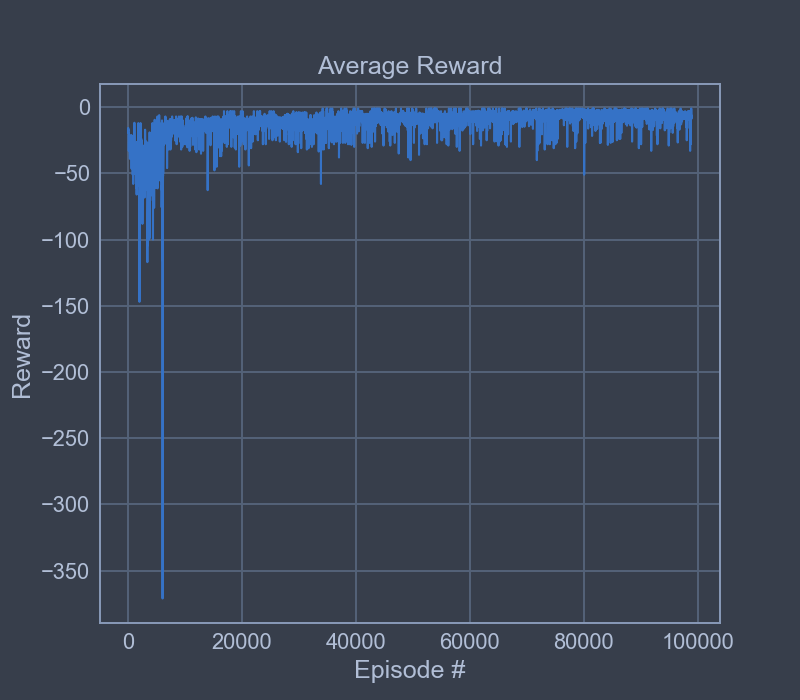

<IPython.core.display.Javascript object>


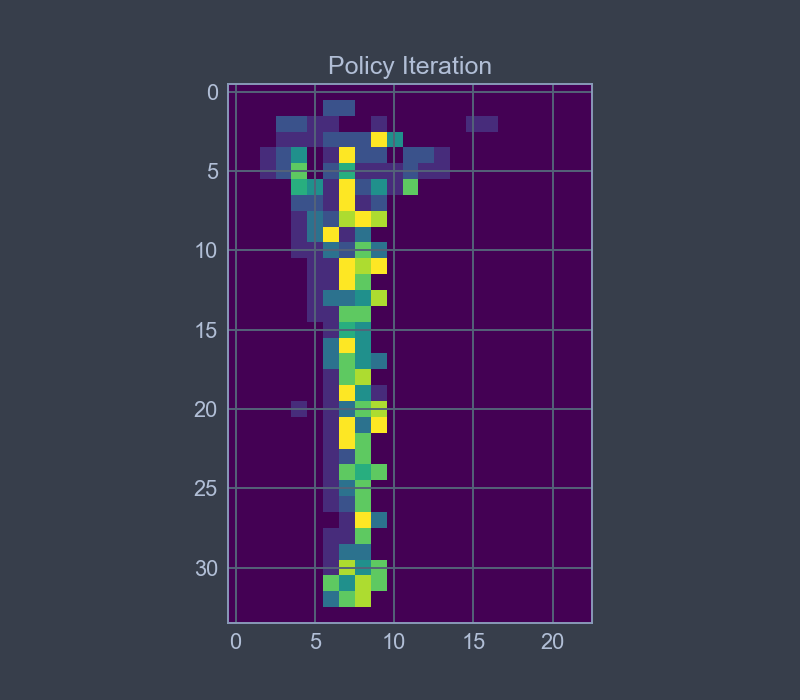

<IPython.core.display.Javascript object>


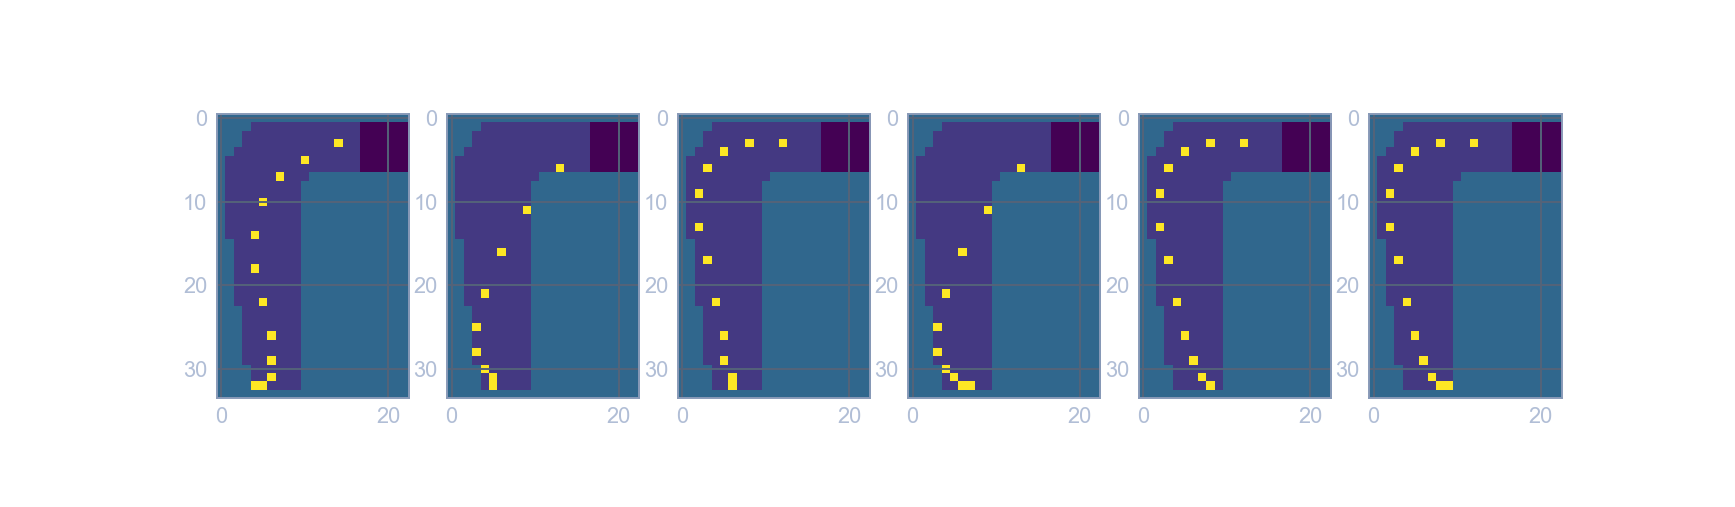

-10.333333333333334


In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import random
import warnings
warnings.simplefilter('error', RuntimeWarning)

from jupyterthemes import jtplot
jtplot.style()

%matplotlib notebook

def make_track():
    track = np.zeros((34, 23))
    track[33, :] = 1
    track[:, 0] = 1
    track[0, :] = 1
    track[:5, 1] = 1
    track[:4, 2] = 1
    track[:2, 3] = 1
    track[15:, 1] = 1
    track[23:, 2] = 1
    track[30:, 3] = 1
    track[8:, 10] = 1
    track[7:, 11:] = 1
    track[1:7, 17:] = -1
    start = [(32, 4), (32, 5), (32, 6), (32, 7), (32, 8), (32, 9)]

    return start, track

def map_to_deltav(action_idx):
    return [(-1,1), (1,0), (1,1), (0,-1), (0,0), (0,1), (-1,-1), (-1,0), (1,-1)][action_idx]

def check_intersection(track, a, b, value):
    points = np.linspace(tuple(a),tuple(b),int(np.abs(np.linalg.norm(b-a)))+1)
    for pt in points:
        if (track[tuple(np.round(pt).astype(int))] == value):
            return True
    return False

def generate_episode(start, track, policy):
    velocity = np.array([0, 0])
    states = []
    rewards = [0] # maintain consistent indexing
    actions = []
    action_probs = []
    position = np.array(list(random.choice(start)))
    crash_count = 0
    prev_position = position
    
    while True:
        states.append(position.copy())
        action, pr = policy(tuple(position), velocity)
        actions.append(action)
        action_probs.append(pr)
        dv = map_to_deltav(action)
        velocity += dv
        bad_action = False
        
        if ((velocity[0] == 0 and dv[0] == 1) or (velocity[1] == 0 and dv[1] == -1)):
            bad_action = True
        velocity[0] = min(max(velocity[0], -5), 1)
        velocity[1] = min(max(velocity[1], -1), 5)
        if (velocity[0] == 0 and velocity[1] == 0):
            velocity[1] = 1
            bad_action = True
        position += velocity
        position[0] = min(max(position[0], 0), 33)
        position[1] = min(max(position[1], 0), 22)
        
        if (check_intersection(track, prev_position, position, 1.0)):
            rewards.append(-12.0)
            if (crash_count < 0):
                position = np.array(list(random.choice(start)))
                velocity = np.array([0, 0])
                crash_count += 1
                continue
            return np.array(states, dtype=int), np.array(rewards, dtype=int), np.array(actions, dtype=int), np.array(action_probs, dtype=float)

        elif (check_intersection(track, prev_position, position, -1.0)):
            rewards.append(12.0)
            return np.array(states, dtype=int), np.array(rewards, dtype=int), np.array(actions, dtype=int), np.array(action_probs, dtype=float)
        
        if bad_action:
            rewards.append(-3)
        elif position[0] < 20:
            rewards.append(-1)
        else:
            rewards.append(-2)
            
        prev_position = position
        
def train(trackinfo):
    N_episodes = 100000
    epsilon = 0.03
    gamma = 0.7
    start, track = trackinfo
    Q = np.zeros(tuple(list(track.shape) + [9]))
    C = np.zeros(tuple(list(track.shape) + [9]))
    pi = np.zeros(tuple(track.shape), dtype=int)
    pis = []
    reward_avgs = []
    
    for i in range(track.shape[0]):
        for j in range(track.shape[1]):
            pi[i, j] = np.argmax(Q[i, j])
            
    def make_soft_policy(pi, epsilon):
        def b(position, velocity):
            rand = random.uniform(0, 1)
            non_greedy = [0,1,2,3,4,5,6,7,8]
            greedy = pi[position]
            if (rand < epsilon):
                return random.choice(non_greedy), epsilon / len(non_greedy)
            else:
                return greedy, 1 - epsilon + epsilon / len(non_greedy)
        return b
    
    reward_avg = 0
    for n in range(N_episodes):
        b = make_soft_policy(pi, epsilon)
        states, rewards, actions, action_prob = generate_episode(start, track, b)
        reward = np.sum(rewards)
        T = len(states)
        G = 0.0
        W = 1.0
        SA = [tuple(np.append(state, action)) for state, action in zip(states, actions)]
        
        if (n % 10000 == 0):
            print('Episode: {}'.format(n))
        
        if (n % 100 == 0):
                reward_avg = reward
                pis.append(pi.copy())
        else:
            reward_avg = reward_avg + 1/(n % 100) * (reward - reward_avg)
            reward_avgs.append(reward_avg)
            
        for t in range(0, T):
            t = T-t-1
            SAt = SA[t]
            G = gamma * G + rewards[t + 1]
            C[SAt] = C[SAt] + W
            Q[SAt] = Q[SAt] + W * (G - Q[SAt]) / C[SAt]
            pi[SAt[:2]] = np.argmax(Q[SAt[:2]])
            
            if SAt[-1] != pi[SAt[:2]]:
                break
            else:
                W = W / action_prob[t]
                
    pis.append(pi.copy())
    return pis, Q, reward_avgs

def validate_policy(track, policy, start):
    states = []
    actions = []
    rewards = []
    position = start
    velocity = np.array([0,0])
    prev_position = position
    
    while True:
        states.append(position.copy())
        action = policy[tuple(position)]
        actions.append(action)
        velocity += map_to_deltav(action)
        velocity[0] = min(max(velocity[0], -5), 1)
        velocity[1] = min(max(velocity[1], -1), 5)
        if (velocity[0] == 0 and velocity[1] == 0):
            print('control')
            velocity[1] = 1
        position += velocity
        position[0] = min(max(position[0], 0), 33)
        position[1] = min(max(position[1], 0), 22)
        if (check_intersection(track, prev_position, position, 1.0)):
            rewards.append(0.0)
            print('fail')
            return np.array(states, dtype=int), np.sum(np.array(rewards, dtype=int)), np.array(actions, dtype=int)

        elif (check_intersection(track, prev_position, position, -1.0)):
            rewards.append(0.0)
            return np.array(states, dtype=int), np.sum(np.array(rewards, dtype=int)), np.array(actions, dtype=int)
        rewards.append(-1.0)
        prev_position = position
        
if __name__ == '__main__':
    start, track = make_track()
    pis, Q, reward_avgs = train((start, track))
    pi = pis[-1]
    pi_imgs = []
    
    plt.figure()
    plt.plot(reward_avgs)
    plt.title('Average Reward')
    plt.xlabel('Episode #')
    plt.ylabel('Reward')

    fig = plt.figure()
    for n, p in enumerate(pis):
        if n < 300:
            im = plt.imshow(p, animated=True)
            pi_imgs.append([im])
        else:
            break
        
    ani = animation.ArtistAnimation(fig, pi_imgs, interval=100, blit=True, repeat_delay=500)  
    plt.show()
    plt.title('Policy Iteration')
    
    rewards = 0
    fig, axs = plt.subplots(1,len(start), facecolor='w', edgecolor='k')
    for i, s in enumerate(start):
        s = np.array(list(s))
        states, reward, actions = validate_policy(track, pi, s)
        rewards += reward
        track_trace = track.copy()
        for s in states:
            track_trace[tuple(s)] = 5
        axs[i].imshow(track_trace)
    fig.canvas.set_window_title('Final Trajectories')
    print(rewards/len(start))
    

In [6]:
def check_intersection(track, a, b, value):
    intersect = False
    points = np.linspace(tuple(a),tuple(b),int(np.abs(np.linalg.norm(b-a)))+1)
    for pt in points:
        print(pt)
        if (track[tuple(np.round(pt).astype(int))] == value):
            intersect = True
        track[tuple(np.round(pt).astype(int))] = -1
    plt.imshow(track)
    return intersect

start, track = make_track()

check_intersection(track.copy(), np.array([9,9]), np.array([6,13]), 1.0)

[9. 9.]
[8.4 9.8]
[ 7.8 10.6]
[ 7.2 11.4]
[ 6.6 12.2]
[ 6. 13.]


True

-1.1666666666666667


<Figure size 460.8x403.2 with 0 Axes>

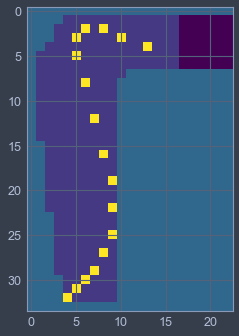

<Figure size 460.8x403.2 with 0 Axes>

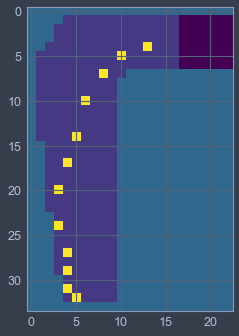

<Figure size 460.8x403.2 with 0 Axes>

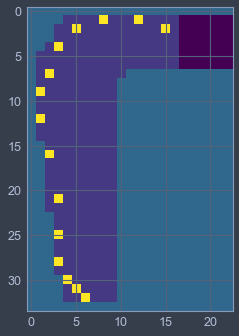

<Figure size 460.8x403.2 with 0 Axes>

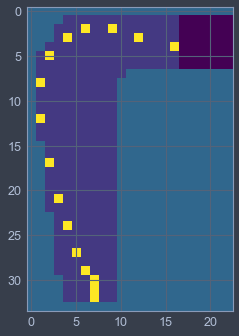

<Figure size 460.8x403.2 with 0 Axes>

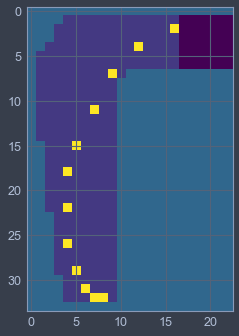

<Figure size 460.8x403.2 with 0 Axes>

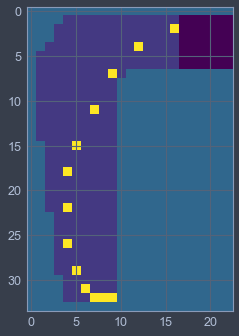

In [910]:
def validate_policy(track, policy, start):
    states = []
    actions = []
    rewards = []
    position = start
    velocity = np.array([0,0])
    prev_position = position
    while True:
        states.append(position.copy())
        action = policy[tuple(position)]
        actions.append(action)
        velocity += map_to_deltav(action)
        velocity[0] = min(max(velocity[0], -5), 1)
        velocity[1] = min(max(velocity[1], -1), 5)
        if (velocity[0] == 0 and velocity[1] == 0):
            print('control')
            velocity[1] = 1
        position += velocity
        position[0] = min(max(position[0], 0), 33)
        position[1] = min(max(position[1], 0), 22)
        if (check_intersection(track, prev_position, position, 1.0)):
            rewards.append(-12.0)
            if (crash_count < 0):
                position = np.array(list(random.choice(start)))
                velocity = np.array([0, 0])
                crash_count += 1
                continue
            return np.array(states, dtype=int), np.sum(np.array(rewards, dtype=int)), np.array(actions, dtype=int)

        elif (check_intersection(track, prev_position, position, -1.0)):
            rewards.append(12.0)
            return np.array(states, dtype=int), np.sum(np.array(rewards, dtype=int)), np.array(actions, dtype=int)
        rewards.append(-1.0)
        prev_position = position

rewards = 0
for s in start:
    s = np.array(list(s))
    states, reward, actions = validate_policy(track, pi, s)
    rewards += reward
    plt.figure()
    track_trace = track.copy()
    for s in states:
        track_trace[tuple(s)] = 5

    plt.figure()
    plt.imshow(track_trace)
print(rewards/len(start))

<IPython.core.display.Javascript object>


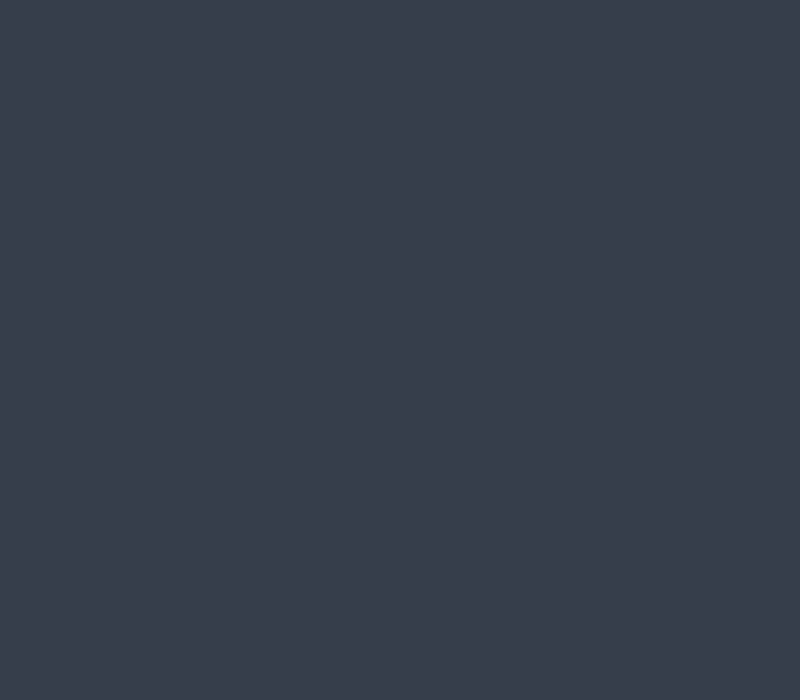

NameError: name 'pis' is not defined

In [3]:

import matplotlib.animation as animation
%matplotlib notebook
fig = plt.figure()

def f(x, y):
    return np.sin(x) + np.cos(y)

x = np.linspace(0, 2 * np.pi, 120)
y = np.linspace(0, 2 * np.pi, 100).reshape(-1, 1)
# ims is a list of lists, each row is a list of artists to draw in the
# current frame; here we are just animating one artist, the image, in
# each frame
ims = []
for p in pis:

    im = plt.imshow(p, animated=True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                repeat_delay=1000)

plt.show()

